# MLND CAPSTONE PROJECT

**Project Summary:**  

In this project, we will train a model that can decode sequences of digits from natural images, and create an app that prints the numbers it sees in real time using Tensorflow library.

The data that we will be using is Street View House Numbers (SVHN), a large-scale dataset of house numbers in Google Street View images.

## Get training and test data

In [1]:
# Import required modules
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
import tensorflow as tf

from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

In [2]:
# Download SVHN data from Stanford University repo
from urllib import urlretrieve
    
url = 'http://ufldl.stanford.edu/housenumbers/'

def maybe_download(filename, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename)
    filename, _ = urlretrieve(url + filename, filename)
    print('Found and downloaded', filename)
  statinfo = os.stat(filename)
  return filename

In [3]:
# Download train, test and extra files for full numbers
train_filename = maybe_download('train.tar.gz')
test_filename = maybe_download('test.tar.gz')

In [4]:
# file extraction

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
    print("Extraction completed.")
  
train_file = maybe_extract(train_filename)
test_file = maybe_extract(test_filename)

train already present - Skipping extraction of train.tar.gz.
test already present - Skipping extraction of test.tar.gz.


Showing a random image from training data:  3177.png


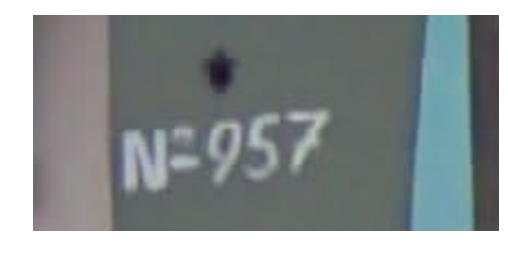

In [5]:
# show a random image from training data
import random
import matplotlib.image as mpimg

train_folder = "./train"
test_folder = "./test"

for path,dirs,files in os.walk(train_folder):
    image_sample = random.sample(files, 1)
    for image in image_sample:
        print("Showing a random image from training data: ", image)
        im = mpimg.imread(('{0}/{1}').format(train_folder, image))
        plt.axis("off")
        plt.imshow(im)
        plt.show()

## Pre-processing data

In [20]:
# Extract image metadata from digitStruct.mat file
# gist source: https://github.com/bvstillwell/udacity/blob/master/p5_deep/svhn_dataextract_tojson.py

import h5py

def remove_anomaly_samples(data, max_class_length = 5):
    """
    Here we remove all data which has class length higher than specified value.
    """
    print("\nDataset size before update:", len(data))
    
    for i in range(len(data)):
        if i < len(data) and len(data[i]['label']) > max_class_length:
            print("\nAnomaly at index %d detected. Class size: %d" % (i, len(data[i]['label'])))
            del data[i]
            
    print("\nDataset after update:", len(data))            
    return data


# The DigitStructFile is just a wrapper around the h5py data.  It basically references 
#     file_:            The input h5 matlab file
#     digitStructName   The h5 ref to all the file names
#     digitStructBbox   The h5 ref to all struc data
class DigitStructsWrapper:
    def __init__(self, file_, start_ = 0, end_ = 0):
        self.file_ = h5py.File(file_, 'r')
        self.names = self.file_['digitStruct']['name'][start_:end_] if end_ > 0 else self.file_['digitStruct']['name']
        self.bboxes = self.file_['digitStruct']['bbox'][start_:end_] if end_ > 0 else self.file_['digitStruct']['bbox']
        self.collectionSize = len(self.names)
        print("\n%s file structure contain %d entries" % (file_, self.collectionSize))
        
        
    def bboxHelper(self, keys_):
        """
        Method handles the coding difference when there is exactly one bbox or an array of bbox. 
        """
        if (len(keys_) > 1):
            val = [self.file_[keys_.value[j].item()].value[0][0] for j in range(len(keys_))]
        else:
            val = [keys_.value[0][0]]
        return val

    
    # getBbox returns a dict of data for the n(th) bbox. 
    def getBbox(self, n):
        bbox = {}
        bb = self.bboxes[n].item()
        bbox['height'] = self.bboxHelper(self.file_[bb]["height"])
        bbox['left'] = self.bboxHelper(self.file_[bb]["left"])
        bbox['top'] = self.bboxHelper(self.file_[bb]["top"])
        bbox['width'] = self.bboxHelper(self.file_[bb]["width"])
        bbox['label'] = self.bboxHelper(self.file_[bb]["label"])
        return bbox

    
    def getName(self, n):
        """
        Method returns the filename for the n(th) digitStruct. Since each letter is stored in a structure 
        as array of ANSII char numbers we should convert it back by calling chr function.
        """
        return ''.join([chr(c[0]) for c in self.file_[self.names[n][0]].value])

    
    def getNumberStructure(self,n):
        s = self.getBbox(n)
        s['name']=self.getName(n)
        return s

    def getAllNumbersStructure(self):
        """
        Method returns an array, which contains information about every image.
        This info contains: positions, labels 
        """
        return [self.getNumberStructure(i) for i in range(self.collectionSize)]

    
    # Return a restructured version of the dataset (one object per digit in 'boxes').
    #
    #   Return a list of dicts :
    #      'filename' : filename of the samples
    #      'boxes' : list of dicts (one by digit) :
    #          'label' : 1 to 9 corresponding digits. 10 for digit '0' in image.
    #          'left', 'top' : position of bounding box
    #          'width', 'height' : dimension of bounding box
    #
    # Note: We may turn this to a generator, if memory issues arise.
    def getAllNumbersRestructured(self): # getAllDigitStructure_ByDigit
        numbersData = self.getAllNumbersStructure()
        print("\nObject structure before transforming: ", numbersData[0])
        remove_anomaly_samples(numbersData)
        
        result = []
        for numData in numbersData:
            metadatas = []
            for i in range(len(numData['height'])):
                metadata = {}
                metadata['height'] = numData['height'][i]
                metadata['label']  = numData['label'][i]
                metadata['left']   = numData['left'][i]
                metadata['top']    = numData['top'][i]
                metadata['width']  = numData['width'][i]
                metadatas.append(metadata)
                
            result.append({ 'boxes':metadatas, 'name':numData["name"] })
            
        print("\nObject structure after transforming: ", result[0])
        
        return result

In [21]:
# image metadata extraction for training folder
file_ = os.path.join(train_folder, 'digitStruct.mat')
dsf = DigitStructsWrapper(file_)
train_data = dsf.getAllNumbersRestructured()


./train/digitStruct.mat file structure contain 33402 entries

Object structure before transforming:  {'name': '1.png', 'top': [77.0, 81.0], 'label': [1.0, 9.0], 'width': [81.0, 96.0], 'height': [219.0, 219.0], 'left': [246.0, 323.0]}

Dataset size before update: 33402

Anomaly at index 29929 detected. Class size: 6

Dataset after update: 33401

Object structure after transforming:  {'boxes': [{'width': 81.0, 'top': 77.0, 'label': 1.0, 'left': 246.0, 'height': 219.0}, {'width': 96.0, 'top': 81.0, 'label': 9.0, 'left': 323.0, 'height': 219.0}], 'name': '1.png'}


In [22]:
# image metadata extraction for test folder
file_ = os.path.join(test_folder, 'digitStruct.mat')
dsf = DigitStructsWrapper(file_)
test_data = dsf.getAllNumbersRestructured()


./test/digitStruct.mat file structure contain 13068 entries

Object structure before transforming:  {'name': '1.png', 'top': [7.0], 'label': [5.0], 'width': [19.0], 'height': [30.0], 'left': [43.0]}

Dataset size before update: 13068

Dataset after update: 13068

Object structure after transforming:  {'boxes': [{'width': 19.0, 'top': 7.0, 'label': 5.0, 'left': 43.0, 'height': 30.0}], 'name': '1.png'}


In [31]:
print("Random sample train data: " + "\n", random.sample(train_data, 1))
print("Random sample test data: " + "\n", random.sample(test_data, 1))

Random sample train data: 
 [{'boxes': [{'width': 11.0, 'top': 7.0, 'label': 3.0, 'left': 28.0, 'height': 30.0}, {'width': 13.0, 'top': 6.0, 'label': 5.0, 'left': 39.0, 'height': 30.0}], 'name': '24775.png'}]
Random sample test data: 
 [{'boxes': [{'width': 20.0, 'top': 24.0, 'label': 2.0, 'left': 60.0, 'height': 29.0}, {'width': 12.0, 'top': 21.0, 'label': 1.0, 'left': 77.0, 'height': 29.0}, {'width': 14.0, 'top': 19.0, 'label': 7.0, 'left': 87.0, 'height': 29.0}, {'width': 11.0, 'top': 17.0, 'label': 6.0, 'left': 104.0, 'height': 29.0}], 'name': '7923.png'}]


In [44]:
from PIL import Image

img_size = 32

def prepare_images(samples, folder):
    print("Started preparing images for convnet...")
    
    prepared_images = np.ndarray([len(samples),img_size,img_size,1], dtype='float32')
    actual_numbers = np.ones([len(samples),6], dtype=int) * 10
    files = []
    for i in range(len(samples)):
        filename = samples[i]['name']
        filepath = os.path.join(folder, filename)
        image = Image.open(filepath)
        boxes = samples[i]['boxes']
        number_length = len(boxes)
        files.append(filename)
        
        # at 0 index we store length of a label. 3 -> 1; 123-> 3, 12543 -> 5
        actual_numbers[i,0] = number_length
        
        top = np.ndarray([number_length], dtype='float32')
        left = np.ndarray([number_length], dtype='float32')
        height = np.ndarray([number_length], dtype='float32')
        width = np.ndarray([number_length], dtype='float32')
        
        for j in range(number_length):
            # here we use j+1 since first entry used by label length
            actual_numbers[i,j+1] = boxes[j]['label']
            if boxes[j]['label'] == 10: # Replacing 10 with 0
                actual_numbers[i,j+1] = 0
                
            top[j] = boxes[j]['top']
            left[j] = boxes[j]['left']
            height[j] = boxes[j]['height']
            width[j] = boxes[j]['width']
        
        img_min_top = np.amin(top)
        img_min_left = np.amin(left)
        img_height = np.amax(top) + height[np.argmax(top)] - img_min_top
        img_width = np.amax(left) + width[np.argmax(left)] - img_min_left

        img_left = np.floor(img_min_left - 0.1 * img_width)
        img_top = np.floor(img_min_top - 0.1 * img_height)
        img_right = np.amin([np.ceil(img_left + 1.2 * img_width), image.size[0]])
        img_bottom = np.amin([np.ceil(img_top + 1.2 * img_height), image.size[1]])
            
        image = image.crop((img_left, img_top, img_right, img_bottom)).resize([img_size, img_size], Image.ANTIALIAS) # Resize image to 32x32
        image = np.dot(np.array(image, dtype='float32'), [[0.2989],[0.5870],[0.1140]]) # Convert image to the grayscale

        mean = np.mean(image, dtype='float32')
        std = np.std(image, dtype='float32', ddof=1)
        if std < 0.0001: 
            std = 1.0
        image = (image - mean) / std
        prepared_images[i,:,:] = image[:,:,:]
        
    print("Completed. Images cropped, resized and grayscaled")
    
    return prepared_images, actual_numbers, files

In [45]:
train_data, train_labels, _ = prepare_images(train_data, train_folder)
print(train_data.shape, train_labels.shape)

Started preparing images for convnet...


TypeError: integer argument expected, got float